In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils

%matplotlib inline

# Running neural structural optimization with torch 🔥 optimizers

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [4]:
# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),


In [5]:
# Initialize the model
model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Set up the Adam optimizer - learning rate has already been adjusted
optimizer = optim.Adam(model.parameters(), lr=4e-3)

# In order to plot the frames and the losses we set up a list
# to append the results
frames = []
losses = []

# These keyword arguments were identified in the original code
kwargs = dict(
    penal=torch.tensor(args["penal"]),
    e_min=torch.tensor(args["young_min"]),
    e_0=torch.tensor(args["young"]),
)

# Put model in training mode
model.train()

for iteration, i in enumerate(range(500)):
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Model
    logits = model(None)
    
    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    loss = torch.sum(compliance_output)
    
    # Append the frames
    frames.append(logits)
    
    if (iteration % 10) == 0:
        print(f'Compliance loss = {loss.item()} / Iteration={iteration}')
        losses.append(loss.item())
    
    # Go through the backward pass and create the gradients
    loss.backward()

    # Step through the optimzer to update the data with the gradients
    optimizer.step()
    
# Render was also used in the original code to create images of the structures
render = [
    topo_physics.physical_density(x, args, volume_constraint=True)
    for x in frames
] 

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:67: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.w = args["nelx"] // tot

Compliance loss = 1874.0818105901733 / Iteration=0
Compliance loss = 523.4347955512898 / Iteration=10
Compliance loss = 456.11049904351734 / Iteration=20
Compliance loss = 393.2011672368886 / Iteration=30
Compliance loss = 356.7095881332942 / Iteration=40
Compliance loss = 322.43692856974917 / Iteration=50
Compliance loss = 289.4059609394518 / Iteration=60
Compliance loss = 270.144974808656 / Iteration=70
Compliance loss = 256.68149751413137 / Iteration=80
Compliance loss = 246.55660258252496 / Iteration=90
Compliance loss = 238.3994589711635 / Iteration=100
Compliance loss = 232.3809185477893 / Iteration=110
Compliance loss = 228.02925956469863 / Iteration=120
Compliance loss = 224.82339734393065 / Iteration=130
Compliance loss = 221.98121457698215 / Iteration=140
Compliance loss = 219.56793674795935 / Iteration=150
Compliance loss = 217.39630034166356 / Iteration=160
Compliance loss = 215.4293501449978 / Iteration=170
Compliance loss = 213.79217405362283 / Iteration=180
Compliance lo

## Plot the structure 🌉

After our model is done training we can plot the final structure.

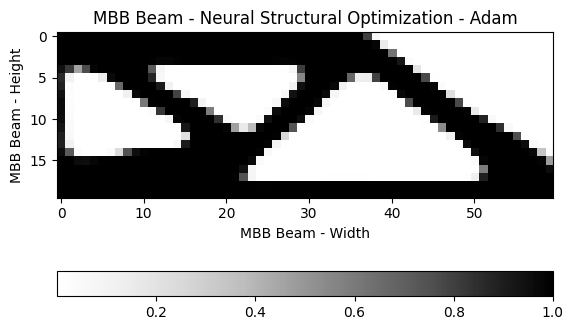

In [6]:
# Get the final frame
final_frame = render[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - Adam')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
fig.colorbar(im, orientation="horizontal", pad=0.2)

# Plot the loss trajectory ☄️

Finally, we will plot the loss directory for **compliance**

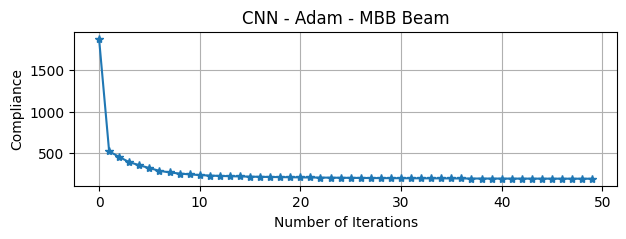

In [7]:
losses = pd.Series(losses)
ax = losses.plot(figsize=(7, 2), marker='*')
ax.set_title('CNN - Adam - MBB Beam')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Compliance')
ax.grid()

# MBB Beam with a larger grid

The next problem that we will try is the MBB beam with a larger grid

In [8]:
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

In [9]:
# Initialize the model
model = models.CNNModel(
    args=args,
)

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Set up the Adam optimizer - learning rate has already been adjusted
optimizer = optim.Adam(model.parameters(), lr=4e-4)

# In order to plot the frames and the losses we set up a list
# to append the results
frames = []
losses = []

# These keyword arguments were identified in the original code
kwargs = dict(
    penal=torch.tensor(args["penal"]),
    e_min=torch.tensor(args["young_min"]),
    e_0=torch.tensor(args["young"]),
)

# Put model in training mode
model.train()

for iteration, i in enumerate(range(500)):
    
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Model
    logits = model(None)
    
    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    loss = torch.sum(compliance_output)
    
    # Append the frames
    frames.append(logits)
    
    if (iteration % 10) == 0:
        print(f'Compliance loss = {loss.item()} / Iteration={iteration}')
        losses.append(loss.item())
    
    # Go through the backward pass and create the gradients
    loss.backward()

    # Step through the optimzer to update the data with the gradients
    optimizer.step()
    
# Render was also used in the original code to create images of the structures
render = [
    topo_physics.physical_density(x, args, volume_constraint=True)
    for x in frames
] 

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_59512/507479846.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_59512/507479846.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),


Compliance loss = 268.9311402426533 / Iteration=0
Compliance loss = 96.69570978182396 / Iteration=10
Compliance loss = 78.69085694706041 / Iteration=20
Compliance loss = 70.24389745083724 / Iteration=30
Compliance loss = 64.72927394534386 / Iteration=40
Compliance loss = 61.0482678182007 / Iteration=50
Compliance loss = 58.223611771745155 / Iteration=60
Compliance loss = 55.73620589854897 / Iteration=70
Compliance loss = 53.65893948630433 / Iteration=80
Compliance loss = 51.777634030313166 / Iteration=90
Compliance loss = 50.10633497900525 / Iteration=100
Compliance loss = 48.77649869858172 / Iteration=110
Compliance loss = 47.67742880119768 / Iteration=120
Compliance loss = 46.71473478355554 / Iteration=130
Compliance loss = 45.853067910143345 / Iteration=140
Compliance loss = 44.99806813019775 / Iteration=150
Compliance loss = 44.25637782409276 / Iteration=160
Compliance loss = 43.5473732232264 / Iteration=170
Compliance loss = 42.87381540720427 / Iteration=180
Compliance loss = 42.2

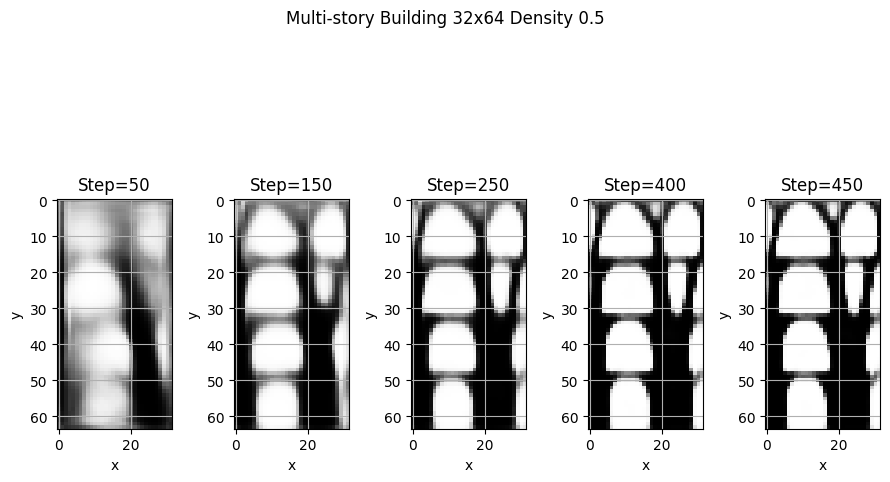

In [37]:
# Get the final frame
# final_frame = render[-1].detach().numpy()
frames = [50, 150, 250, 400, 450]

# Create a figure and axis
fig, axes = plt.subplots(1, 5, figsize=(9, 6))
axes = axes.flatten()

for idx, frames in enumerate(frames):
    # Show the structure in grayscale
    im = axes[idx].imshow(render[frames].detach().numpy(), cmap='Greys')
    axes[idx].set_ylabel('y')
    axes[idx].set_xlabel('x')
    axes[idx].grid()
    axes[idx].set_title(f'Step={frames}')
    
plt.suptitle('Multi-story Building 32x64 Density 0.5')
fig.tight_layout()

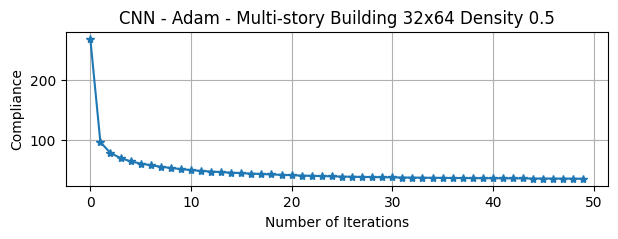

In [38]:
losses = pd.Series(losses)
ax = losses.plot(figsize=(7, 2), marker='*')
ax.set_title('CNN - Adam - Multi-story Building 32x64 Density 0.5')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Compliance')
ax.grid()